In [1]:
import xarray as xr
import numpy as np 

In [2]:
file_path = f"../data/raw/Tmax_20010101_20240320_BR-DWGD_UFES_UTEXAS_v_3.2.3.nc"
cur_df = xr.open_dataset(file_path, engine="netcdf4")

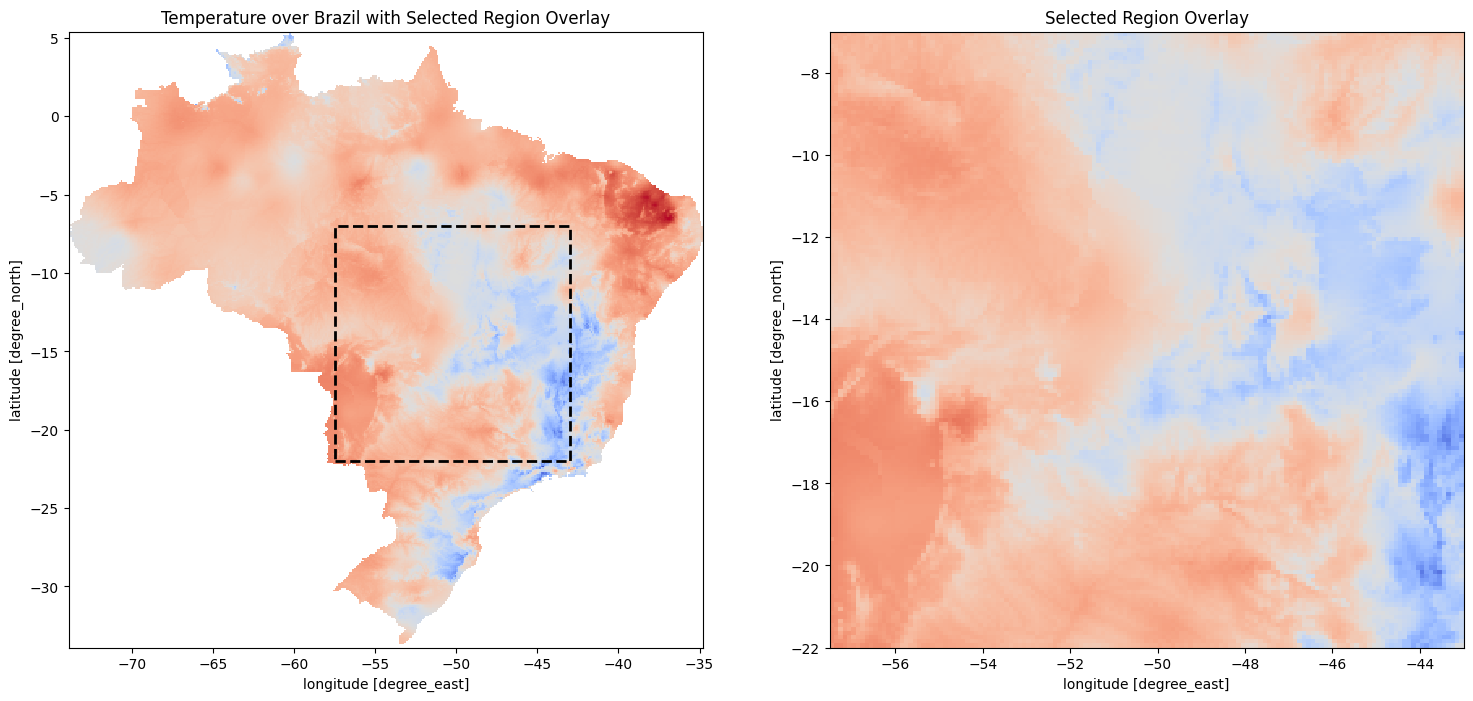

In [3]:
import matplotlib.pyplot as plt

lat_min, lat_max = -22.0, -7.0
lon_min, lon_max = -57.5, -43.0
cropped = cur_df.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Background: Full Brazil
cur_df.Tmax.isel(time=0).plot(ax=axs[0], cmap='coolwarm', add_colorbar=False)
cropped.Tmax.isel(time=0).plot(ax=axs[1], cmap='coolwarm', add_colorbar=False,vmin=cur_df.Tmax.isel(time=0).min(), vmax=cur_df.Tmax.isel(time=0).max())

# Overlay: São Paulo (as contour or colormap)

# Optional: Draw bounding box
axs[0].plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, linestyle='--', label='Selected Region')

# Final touches
axs[0].set_title("Temperature over Brazil with Selected Region Overlay")
axs[1].set_title("Selected Region Overlay")

plt.show()

In [ ]:
plt.hist(cropped.Tmax.values.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of Tmax values (cropped region)')
plt.show()

In [ ]:
new_vals = (cropped.Tmax.values - np.nanmean(cropped.Tmax.values))/np.nanstd(cropped.Tmax.values)

In [ ]:
np.nanmin(new_vals), np.nanmax(new_vals)

(-7.46921396917096, 3.927038870478597)

In [ ]:
np.nanmean(new_vals), np.nanstd(new_vals)

(2.2873306959425036e-14, 0.9999999999999982)

In [ ]:
new_vals.shape

(8480, 150, 145)

In [ ]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')


In [ ]:
from src.data_manager import BrazilWeatherDataset, transforms

dataset = BrazilWeatherDataset( transform=None,
                                surf_vars=['Tmin','Tmax'],
                                static_vars=None,
                                lat_lim=[-22.0, -7.0], lon_lim=[-57.5, -43.0])

In [ ]:
dataset.imgs.mean(dim=(0,2,3)), dataset.imgs.std(dim=(0,2,3))

(tensor([18.9116, 31.1490]), tensor([3.2707, 3.2754]))

In [ ]:
dataset.imgs.amin(dim=(0,2,3)), dataset.imgs.amax(dim=(0,2,3))

(tensor([-5.8673,  7.6554]), tensor([31.4837, 44.7031]))

In [ ]:
rand_transform = transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),
        transforms.Normalize(
            (18.9116, 31.1490), #'Tmin', 'Tmax',
            (3.2707, 3.2754))
    ])


In [ ]:
dataset.imgs.shape

torch.Size([23090, 2, 150, 145])

In [ ]:
t_dataset = rand_transform(dataset.imgs)

In [ ]:
t_dataset.amin(dim=(0,2,3)), t_dataset.amax(dim=(0,2,3))

(tensor([-6.9798, -7.0872]), tensor([4.0726, 4.1556]))